In [ ]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataM.h5 to dataM.h5


In [ ]:
# Open the H5 file
file = h5py.File('dataM.h5', 'r')

# Create empty lists to store the preprocessed data
Matrix_13_data = []
Matrix_16_data = []

In [ ]:
for i in range(1, 1001):
    # Construct the dataset paths
    Matrix_13_path = f"dataset_group/Matrix_13_{i}"
    Matrix_16_path = f"dataset_group/Matrix_16_{i}"
    # Load vector_13 and vector_16 from the H5 file
    Matrix_13 = np.array(file[Matrix_13_path])
    Matrix_16 = np.array(file[Matrix_16_path])

    # Add the data to the respective lists
    Matrix_13_data.append(Matrix_13)
    Matrix_16_data.append(Matrix_16)

# Close the H5 file
file.close()

In [ ]:
# Convert the lists to numpy arrays
Matrix_13_data = np.array(Matrix_13_data)
Matrix_16_data = np.array(Matrix_16_data)

# Normalize the data (optional, good idea?)
# vector_13_data = vector_13_data / np.max(vector_13_data)
# vector_16_data = vector_16_data / np.max(vector_16_data)

# Reshape Matrix_13_data to (1000, 16, 16) and Matrix_16_data to (1000, 16, 16)
Matrix_13_data = np.reshape(Matrix_13_data, (1000, 16, 16))
Matrix_16_data = np.reshape(Matrix_16_data, (1000, 16, 16))

In [ ]:
# Split the dataset into training and testing sets
train_ratio = 0.8
train_size = int(train_ratio * Matrix_13_data.shape[0])

x_train = Matrix_13_data[:train_size]
y_train = Matrix_16_data[:train_size]

x_test = Matrix_13_data[train_size:]
y_test = Matrix_16_data[train_size:]

In [ ]:
# Sanity check
tf.config.list_physical_devices('GPU')

[]

In [ ]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (800, 16, 16)
Shape of y_train: (800, 16, 16)
Shape of x_test: (200, 16, 16)
Shape of y_test: (200, 16, 16)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (16, 16, 1)

# Define the size of the encoded representation
encoding_dim = 32

# Input layer
input_matrix = Input(shape=input_shape)

# Encoder
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input_matrix)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = Flatten()(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(256, activation='relu')(encoded)
decoded = Reshape((16, 16, 1))(decoded)
decoded = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2DTranspose(1, (3, 3), padding='same', activation='linear')(decoded)

# Create the autoencoder model
autoencoder = Model(input_matrix, decoded)

# Compile and train the model
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(x_train, y_train, epochs=50, batch_size=32, shuffle=True, validation_data=(x_test, y_test))

weights = autoencoder.get_weights()

# Define the hypermatrix W as the learned weights
W = tf.Variable(tf.constant(weights[0]))



Epoch 1/50
25/25 [==============================] - 2s 36ms/step - loss: 409.5653 - val_loss: 7.4627
Epoch 2/50
25/25 [==============================] - 1s 30ms/step - loss: 287.0285 - val_loss: 3.7407
Epoch 3/50
25/25 [==============================] - 1s 31ms/step - loss: 211.2363 - val_loss: 4.1515
Epoch 4/50
25/25 [==============================] - 1s 30ms/step - loss: 193.6173 - val_loss: 2.3234
Epoch 5/50
25/25 [==============================] - 2s 73ms/step - loss: 213.5874 - val_loss: 2.1443
Epoch 6/50
25/25 [==============================] - 2s 73ms/step - loss: 171.1987 - val_loss: 4.0002
Epoch 7/50
25/25 [==============================] - 2s 80ms/step - loss: 170.3867 - val_loss: 3.4900
Epoch 8/50
25/25 [==============================] - 1s 57ms/step - loss: 115.4197 - val_loss: 1.9379
Epoch 9/50
25/25 [==============================] - 1s 40ms/step - loss: 94.8920 - val_loss: 4.5653
Epoch 10/50
25/25 [==============================] - 1s 29ms/step - loss: 138.1735 - val_los

In [ ]:
print("Dimensions of W:", W.shape)
print(len(weights))

Dimensions of W: (32, 16, 16, 1)
14


In [ ]:
W = tf.Variable(tf.random.normal(shape=(encoding_dim, 16, 16, 1)))
print("Dimensions of W:", W.shape)

Dimensions of W: (32, 16, 16, 1)


In [ ]:
# Print the summary of the autoencoder model
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 16)        160       
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 32)                262176    
                                                                 
 dense_11 (Dense)            (None, 256)               8448      
                                                                 
 reshape_5 (Reshape)         (None, 16, 16, 1)         0   

In [ ]:

# Generate the predicted matrix using einsum
y_pred = tf.einsum('aij,kjlm->aklm', input_matrix, W)

# Evaluation
# Select a random index from the test set
random_index = np.random.randint(low=0, high=x_test.shape[0])

# Select the predicted and ground truth matrices at the random index
predicted_matrix = y_pred[random_index]
ground_truth_matrix = y_test[random_index]

# Print the selected matrices for comparison
print("Predicted Matrix:")
print(predicted_matrix)
print("Ground Truth Matrix:")
print(ground_truth_matrix)

ValueError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (16, 16, 1)

# Define the size of the encoded representation
encoding_dim = 32

# Custom constraint to ensure column sums add up to zero
def column_sum_constraint(x):
    column_sums = tf.reduce_sum(x, axis=0)
    return x - column_sums / tf.cast(tf.shape(x)[0], dtype=x.dtype)

# Input layer
input_matrix = Input(shape=input_shape)

# Encoder
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input_matrix)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = Flatten()(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(256, activation='relu')(encoded)
decoded = Reshape((16, 16, 1))(decoded)
decoded = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2DTranspose(1, (3, 3), padding='same')(decoded)
decoded = Lambda(column_sum_constraint)(decoded)  # Apply column sum constraint

# Create the autoencoder model
autoencoder = Model(input_matrix, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')  # Use mean squared error (MSE) loss for matrix reconstruction

# Train the model
autoencoder.fit(x_train, y_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, y_test))


Epoch 1/50
25/25 [==============================] - 2s 57ms/step - loss: 411.8448 - val_loss: 9.1210
Epoch 2/50
25/25 [==============================] - 1s 33ms/step - loss: 368.3781 - val_loss: 7.1035
Epoch 3/50
25/25 [==============================] - 1s 29ms/step - loss: 248.7757 - val_loss: 6.1708
Epoch 4/50
25/25 [==============================] - 1s 30ms/step - loss: 214.1652 - val_loss: 5.3862
Epoch 5/50
25/25 [==============================] - 1s 29ms/step - loss: 177.7445 - val_loss: 5.0879
Epoch 6/50
25/25 [==============================] - 1s 30ms/step - loss: 143.2055 - val_loss: 5.3091
Epoch 7/50
25/25 [==============================] - 1s 30ms/step - loss: 127.3984 - val_loss: 5.4891
Epoch 8/50
25/25 [==============================] - 1s 29ms/step - loss: 111.9948 - val_loss: 5.5794
Epoch 9/50
25/25 [==============================] - 1s 29ms/step - loss: 202.9166 - val_loss: 6.6690
Epoch 10/50
25/25 [==============================] - 1s 30ms/step - loss: 130.2641 - val_lo

In [ ]:
# Evaluation
reconstructed_matrices = autoencoder.predict(y_test)

# Select a random vector from the test set
random_index = np.random.randint(low=0, high=y_test.shape[0])

predicted_matrix = reconstructed_matrices[random_index]
ground_truth_matrix = y_test[random_index]

print("Predicted Matrix:")
print(predicted_matrix)
print("Ground Truth Matrix:")
print(ground_truth_matrix)

7/7 [==============================] - 0s 8ms/step
Predicted Matrix:
[[[ 4.42712708e+01]
  [-1.93351479e+01]
  [-4.98880291e+00]
  [-2.34373951e+00]
  [ 4.24609721e-01]
  [-1.33873355e+00]
  [-1.31138933e+00]
  [-8.33886266e-01]
  [ 9.54974413e-01]
  [ 7.69242048e-01]
  [-2.31121922e+00]
  [-5.01416087e-01]
  [-3.37323844e-01]
  [ 2.15357494e+00]
  [-1.09574866e+00]
  [-1.42642803e+01]]

 [[-2.32500648e+01]
  [ 4.11967087e+01]
  [-1.09357748e+01]
  [-5.93044853e+00]
  [-2.77071977e+00]
  [-1.15563703e+00]
  [ 1.28318176e-01]
  [-5.75101852e-01]
  [-1.05473161e+00]
  [ 2.38974661e-01]
  [ 4.11431849e-01]
  [-1.58032012e+00]
  [-6.86016083e-01]
  [-1.16264606e+00]
  [ 3.49583673e+00]
  [-1.32576108e+00]]

 [[-1.14382732e+00]
  [-1.34820061e+01]
  [ 3.66032600e+01]
  [-1.01189098e+01]
  [-1.28333494e-01]
  [ 1.33397651e+00]
  [-2.87460804e+00]
  [ 2.38111913e-02]
  [-1.93528366e+00]
  [-2.70868599e-01]
  [ 7.19971538e-01]
  [ 5.94580531e-01]
  [ 2.60195807e-02]
  [-3.24415207e+00]
  [-3.1

[-2.44312197  0.98006973  0.11178839  0.04929555  0.02984202  0.02144127
  0.01727327  0.01515527  0.01418245  0.01388326  0.01433     0.01772295
  0.02812924  0.04962719  0.11260405  0.96777732  0.98006973 -2.45930998
  0.98292826  0.11164919  0.04924175  0.0298452   0.02144693  0.01725863
  0.01503259  0.01374043  0.01298414  0.01407896  0.01956681  0.02967915
  0.04971317  0.11207504  0.11178839  0.98292826 -2.45868198  0.97895921
  0.11169939  0.04929151  0.02985838  0.02144457  0.01716198  0.01461958
  0.01278635  0.01239677  0.01535996  0.02097115  0.02997474  0.04944174
  0.04929555  0.11164919  0.97895921 -2.44269875  0.96703515  0.11166784
  0.04927171  0.02987675  0.02140062  0.01680629  0.01362802  0.01193153
  0.01327312  0.01662111  0.02138497  0.0298977   0.02984202  0.04924175
  0.11169939  0.96703515 -2.44359633  0.97983118  0.11174259  0.04939061
  0.02994564  0.02114691  0.01578125  0.0125031   0.01248005  0.01442047
  0.01710697  0.02142927  0.02144127  0.0298452   0

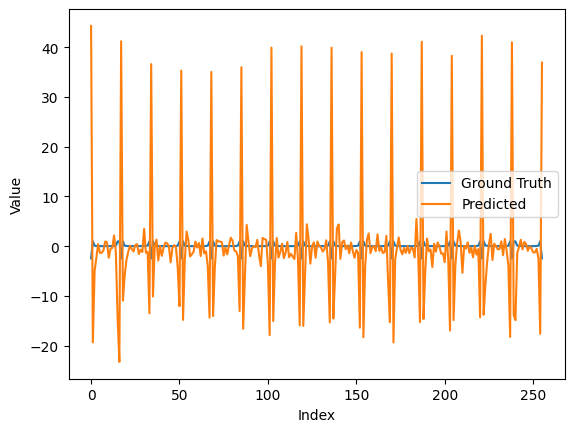

In [ ]:
import matplotlib.pyplot as plt

# Flatten the ground truth and predicted matrices
ground_truth_vector = np.array(ground_truth_matrix, order='F').flatten()
predicted_vector = np.array(predicted_matrix, order='F').flatten()

print(ground_truth_vector)
# Create x-axis values for the plot
x = range(len(ground_truth_vector))

# Plot the ground truth and predicted vectors
plt.plot(x, ground_truth_vector, label='Ground Truth')
plt.plot(x, predicted_vector, label='Predicted')

# Set plot labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()